In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional
from tensorflow.keras.activations import linear

In [26]:
#Load Data
data_train = pd.read_csv("./Data/train.txt", sep=";", header=None, names=['text', 'emotion'])
data_val = pd.read_csv("./Data/val.txt", sep=";", header=None, names=['text', 'emotion'])
data_test = pd.read_csv("./Data/test.txt", sep=";", header=None, names=['text', 'emotion'])

In [27]:
data_train.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [28]:
print("Train shape:", data_train.shape)
print("Validation shape: ", data_val.shape)
print("Test shape: ", data_test.shape)

Train shape: (16000, 2)
Validation shape:  (2000, 2)
Test shape:  (2000, 2)


In [29]:
#Get emotions
emotions = data_train['emotion'].unique().tolist()
print(f"List of emotions: {emotions}")

List of emotions: ['sadness', 'anger', 'love', 'surprise', 'fear', 'joy']


In [30]:
#Create Dictionary of classes
classes = {}
for emotion in emotions:
    classes[emotion] = emotions.index(emotion)
    
print(classes)

{'sadness': 0, 'anger': 1, 'love': 2, 'surprise': 3, 'fear': 4, 'joy': 5}


In [31]:
#Replace classes
data_train['emotion'] = data_train['emotion'].map(classes)
data_val['emotion'] = data_val['emotion'].map(classes)
data_test['emotion'] = data_test['emotion'].map(classes)

In [32]:
#data_train['original_text'] = data_train.loc[:, 'text']

In [33]:
data_train.head()

,text,emotion
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,1
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,1


In [34]:
from collections import Counter

#Get word counts in data
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

In [35]:
counter = counter_word(data_train.text)
num_unique_words = len(counter)
print(f"Unique words: {num_unique_words}")

Unique words: 15212


In [36]:
print(f"Most common words: {counter.most_common(5)}")

Most common words: [('i', 25859), ('feel', 11183), ('and', 9589), ('to', 8972), ('the', 8370)]


In [37]:
#Create text and label arrays
train_x = data_train.text.to_numpy()
train_y = data_train.emotion.to_numpy()

val_x = data_val.text.to_numpy()
val_y = data_val.emotion.to_numpy()

test_x = data_test.text.to_numpy()
test_y = data_test.emotion.to_numpy()

In [38]:
#Create tokenizer
tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(train_x)

In [39]:
word_index = tokenizer.word_index
print(f"Tokenized words:")
word_index

Tokenized words:


{'i': 1,
 'feel': 2,
 'and': 3,
 'to': 4,
 'the': 5,
 'a': 6,
 'feeling': 7,
 'that': 8,
 'of': 9,
 'my': 10,
 'in': 11,
 'it': 12,
 'like': 13,
 'so': 14,
 'for': 15,
 'im': 16,
 'me': 17,
 'but': 18,
 'was': 19,
 'have': 20,
 'is': 21,
 'this': 22,
 'am': 23,
 'with': 24,
 'not': 25,
 'about': 26,
 'be': 27,
 'as': 28,
 'on': 29,
 'you': 30,
 'just': 31,
 'at': 32,
 'when': 33,
 'or': 34,
 'all': 35,
 'because': 36,
 'more': 37,
 'do': 38,
 'can': 39,
 'really': 40,
 'up': 41,
 't': 42,
 'are': 43,
 'by': 44,
 'very': 45,
 'know': 46,
 'been': 47,
 'if': 48,
 'out': 49,
 'myself': 50,
 'time': 51,
 'how': 52,
 'what': 53,
 'get': 54,
 'little': 55,
 'had': 56,
 'now': 57,
 'will': 58,
 'from': 59,
 'being': 60,
 'they': 61,
 'people': 62,
 'them': 63,
 'would': 64,
 'he': 65,
 'want': 66,
 'her': 67,
 'some': 68,
 'think': 69,
 'one': 70,
 'still': 71,
 'ive': 72,
 'him': 73,
 'even': 74,
 'who': 75,
 'an': 76,
 'life': 77,
 'its': 78,
 'make': 79,
 'there': 80,
 'we': 81,
 'bit': 82

In [40]:
#Create tokenized text sequences
train_sequences = tokenizer.texts_to_sequences(train_x)
val_sequences = tokenizer.texts_to_sequences(val_x)
test_sequences = tokenizer.texts_to_sequences(test_x)
max_length = len(max(train_sequences, key=len))

In [41]:
#Create Padded sequences
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating="post")
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding='post', truncating="post")
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating="post")

In [42]:
#Get reversed tokenizer word index
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])

In [43]:
print(f"Reversed word index:")
reverse_word_index

Reversed word index:


{1: 'i',
 2: 'feel',
 3: 'and',
 4: 'to',
 5: 'the',
 6: 'a',
 7: 'feeling',
 8: 'that',
 9: 'of',
 10: 'my',
 11: 'in',
 12: 'it',
 13: 'like',
 14: 'so',
 15: 'for',
 16: 'im',
 17: 'me',
 18: 'but',
 19: 'was',
 20: 'have',
 21: 'is',
 22: 'this',
 23: 'am',
 24: 'with',
 25: 'not',
 26: 'about',
 27: 'be',
 28: 'as',
 29: 'on',
 30: 'you',
 31: 'just',
 32: 'at',
 33: 'when',
 34: 'or',
 35: 'all',
 36: 'because',
 37: 'more',
 38: 'do',
 39: 'can',
 40: 'really',
 41: 'up',
 42: 't',
 43: 'are',
 44: 'by',
 45: 'very',
 46: 'know',
 47: 'been',
 48: 'if',
 49: 'out',
 50: 'myself',
 51: 'time',
 52: 'how',
 53: 'what',
 54: 'get',
 55: 'little',
 56: 'had',
 57: 'now',
 58: 'will',
 59: 'from',
 60: 'being',
 61: 'they',
 62: 'people',
 63: 'them',
 64: 'would',
 65: 'he',
 66: 'want',
 67: 'her',
 68: 'some',
 69: 'think',
 70: 'one',
 71: 'still',
 72: 'ive',
 73: 'him',
 74: 'even',
 75: 'who',
 76: 'an',
 77: 'life',
 78: 'its',
 79: 'make',
 80: 'there',
 81: 'we',
 82: 'bit'

In [44]:
#Create decoder
def decode(sequence):
    return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])

In [45]:
#Decode first sequence
decoded_text = decode(train_sequences[0])

print(f"Sequence: {train_sequences[0]}")
print(f"Decoded sequence: {decoded_text}")

Sequence: [1, 138, 2, 678]
Decoded sequence: i didnt feel humiliated


In [46]:
model = Sequential(
    [   
        Embedding(num_unique_words, 64, input_length=max_length),               
        
        Bidirectional(LSTM(256, dropout=0.7, return_sequences=True)),
        Bidirectional(LSTM(256, dropout=0.7)),

        Dense(6, activation='linear')
        
    ], name = "my_model" 
)


2024-11-20 07:58:06.554791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-20 07:58:06.555471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-20 07:58:06.556304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [47]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 66, 64)            973568    
                                                                 
 bidirectional_2 (Bidirectio  (None, 66, 512)          657408    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 512)              1574912   
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 3,208,966
Trainable params: 3,208,966
Non-trainable params: 0
_________________________________________________________________


In [24]:
#Compile and fit
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

history = model.fit(
    train_padded, train_y,
    batch_size = 32,
    validation_data = (val_padded, val_y),
    epochs = 10
)

Epoch 1/10


2024-11-20 07:58:07.128932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-20 07:58:07.129876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-20 07:58:07.130455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

500/500 [==============================] - ETA: 0s - loss: 1.2696 - accuracy: 0.4997

2024-11-20 08:00:07.620770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-20 08:00:07.621929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-20 08:00:07.622619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

500/500 [==============================] - 128s 251ms/step - loss: 1.2696 - accuracy: 0.4997 - val_loss: 0.5917 - val_accuracy: 0.7680
Epoch 2/10
500/500 [==============================] - 122s 244ms/step - loss: 0.4673 - accuracy: 0.8341 - val_loss: 0.3148 - val_accuracy: 0.8910
Epoch 3/10
500/500 [==============================] - 121s 243ms/step - loss: 0.2671 - accuracy: 0.9053 - val_loss: 0.2366 - val_accuracy: 0.9120
Epoch 4/10
490/500 [============================>.] - ETA: 2s - loss: 0.2023 - accuracy: 0.9261

In [31]:
model.save('my_model.h5')  # 保存为HDF5格式文件

<function matplotlib.pyplot.show(close=None, block=None)>

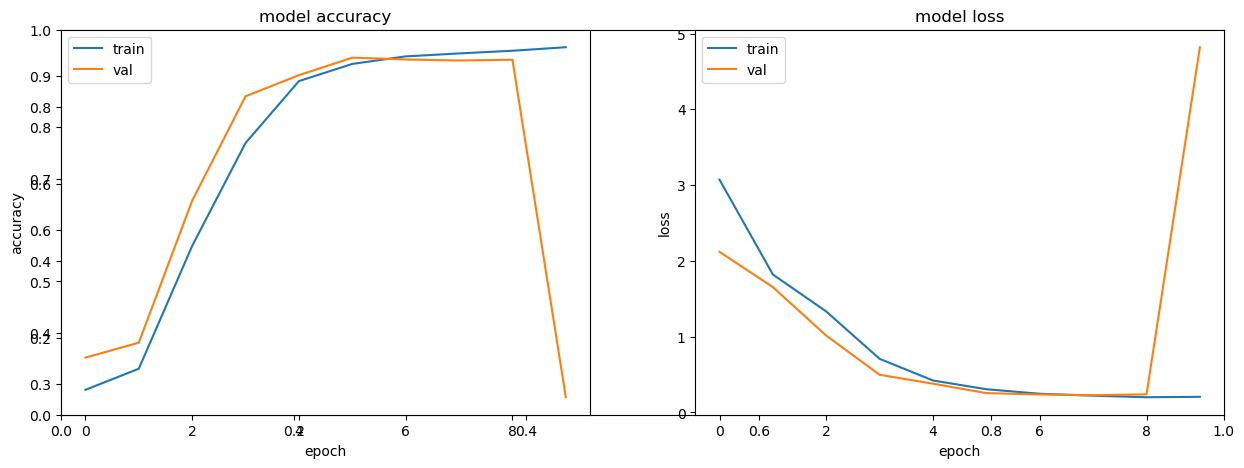

In [28]:
#PLot accuracy and loss function history
plt.subplots(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show



In [29]:
#Predict test sequences
prediction = model.predict(test_padded)

print(f"\n Emotions: {emotions}")

for i in range(6):
    decoded_text = decode(test_sequences[i])
    predicted_index = np.argmax(prediction[i])
    emotion = emotions[int(predicted_index)]
    
    print(f"\n Text: {decoded_text}")
    print(f" Prediction: {prediction[i]}")
    print(f" Largest Prediction index: {predicted_index}")
    print(f" Emotion: {emotion}")

63/63 [==============================] - 38s 599ms/step

 Emotions: ['sadness', 'anger', 'love', 'surprise', 'fear', 'joy']

 Text: im feeling rather rotten so im not very ambitious right now
 Prediction: [ 4.0370984 -1.3360142 -7.386217  -4.624039   0.2673729 -3.2701342]
 Largest Prediction index: 0
 Emotion: sadness

 Text: im updating my blog because i feel shitty
 Prediction: [ 3.8517725  0.6306153 -6.415977  -4.8911157 -0.5846047 -2.4720614]
 Largest Prediction index: 0
 Emotion: sadness

 Text: i never make her separate from me because i don t ever want her to feel like i m ashamed with her
 Prediction: [ 4.1118283   0.23241515 -6.71523    -5.0988812  -0.27525955 -2.8169386 ]
 Largest Prediction index: 0
 Emotion: sadness

 Text: i left with my of red and yellow under my arm feeling slightly more optimistic than when i arrived
 Prediction: [ 4.1834855  1.1172161 -6.8073506 -5.2686687  1.0296228 -3.4009836]
 Largest Prediction index: 0
 Emotion: sadness

 Text: i was feeling a lit

In [30]:
#Get accuracy and loss values
print(f"train loss, train acc: {history.history['loss'][-1]}, {history.history['accuracy'][-1]}")
print(f"val loss, val acc: {history.history['val_loss'][-1]}, {history.history['val_accuracy'][-1]}\n")

results = model.evaluate(test_padded, test_y, batch_size=32)
print("test loss, test acc:", results)

train loss, train acc: 0.20551684498786926, 0.9553124904632568
val loss, val acc: 4.8198957443237305, 0.2750000059604645

63/63 [==============================] - 37s 589ms/step - loss: 4.6175 - accuracy: 0.2920
test loss, test acc: [4.617462635040283, 0.2919999957084656]
